# 🌧️ Predicting Next Day Rainfall for a given location using Decision Tress and Random Forest

## Problem Statement

Applying _Decision Trees_ and _Random Forest_ to a real-world dataset from [Kaggle](https://kaggle.com/datasets):

> **QUESTION**: The [Rain in Australia dataset](https://kaggle.com/jsphyg/weather-dataset-rattle-package) contains about 10 years of daily weather observations from numerous Australian weather stations. Here's a small sample from the dataset:
> 
> ![](https://i.imgur.com/5QNJvir.png)
>
> As a data scientist at the Bureau of Meteorology, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow. 
>
>
> ![](https://i.imgur.com/KWfcpcO.png)

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [2]:
# Load the dataset
raw_df = pd.read_csv("../data/weatherAUS.csv")
raw_df.dropna(subset=["RainToday", "RainTomorrow"], inplace=True)

### Training, Validation and Test Sets

In [3]:
# Create training, validation and test sets
year = pd.to_datetime(raw_df.Date).dt.year
train_df, val_df, test_df = (
    raw_df[year < 2015],
    raw_df[year == 2015],
    raw_df[year > 2015],
)

# Create inputs and targets
input_cols = list(train_df.columns)[1:-1]
target_col = "RainTomorrow"

train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy()

In [4]:
# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes("object").columns.tolist()


In [5]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore").fit(
    raw_df[categorical_cols]
)

In [6]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [7]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

/var/folders/d3/399k69l53y170wj7fmjtwd240000gn/T/ipykernel_38686/1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
/var/folders/d3/399k69l53y170wj7fmjtwd240000gn/T/ipykernel_38686/1584174743.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
/var/folders/d3/399k69l53y170wj7fmjtwd240000gn/T/ipykernel_38686/1584174743.py:1: PerformanceWarning: DataFrame is highl

## Training and Visualizing Decision Trees

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

### Training

In [8]:
from sklearn.tree import DecisionTreeClassifier

In [9]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [10]:
model =  DecisionTreeClassifier(random_state=42)


In [11]:
%%time
model.fit(X_train, train_targets)

CPU times: user 1.69 s, sys: 96.2 ms, total: 1.79 s
Wall time: 1.94 s


DecisionTreeClassifier(random_state=42)

### Evaluation

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
train_preds = model.predict(X_train)

In [14]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'],
      shape=(97988,), dtype=object)

In [15]:
pd.value_counts(train_preds)

/var/folders/d3/399k69l53y170wj7fmjtwd240000gn/T/ipykernel_38686/1258350197.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_preds)


No     76211
Yes    21777
Name: count, dtype: int64

In [17]:
# The decision tree also returns probabilities for each prediction.
train_probs = model.predict_proba(X_train)
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], shape=(97988, 2))

In [18]:
accuracy_score(train_preds, train_targets)

0.998275299016206

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [20]:
model.score(X_val, val_targets)

0.7917958920943297

Although the training accuracy is 100%, the accuracy on the validation set is just about 79%, which is only marginally better then always predicting "No". 

In [21]:
val_targets.value_counts() / len(val_targets)

RainTomorrow
No     0.790626
Yes    0.209374
Name: count, dtype: float64

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called "overfitting", and reducing overfitting is one of the most important parts of any machine learning project.

### Visualization

We can visualize the decision tree _learned_ from the training data.

In [22]:
from sklearn.tree import plot_tree, export_text
import seaborn as sns
import matplotlib.pyplot as plt


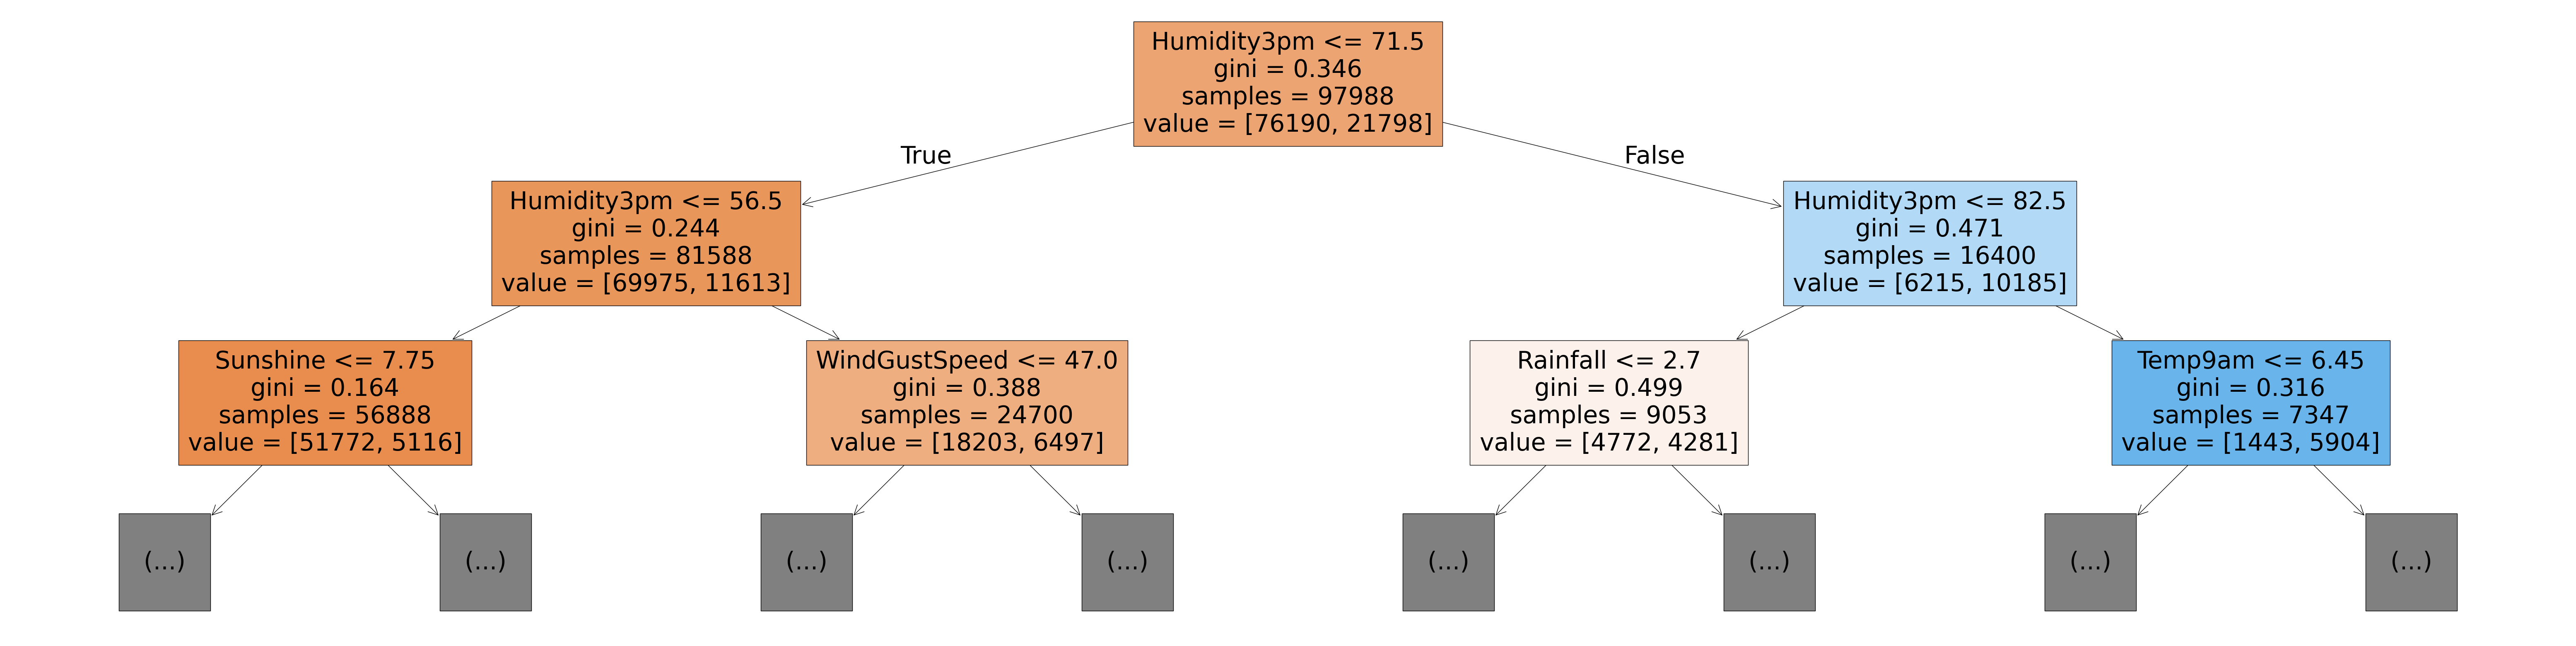

In [23]:
plt.figure(figsize=(80, 20))
plot_tree(
    model,
    feature_names=X_train.columns,
    max_depth=2,
    filled=True,
)
plt.show()

**How a Decision Tree is Created**

Note the `gini` value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower `Gini index` indicates a better split. A perfect split (only one class on each side) has a Gini index of 0.

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

In [24]:
model.tree_.max_depth

43

In [25]:
tree_text = export_text(
    model,
    max_depth=10,
    feature_names=list(X_train.columns),
)
print(tree_text[:5000])

|--- Humidity3pm <= 71.50
|   |--- Humidity3pm <= 56.50
|   |   |--- Sunshine <= 7.75
|   |   |   |--- Pressure3pm <= 1013.35
|   |   |   |   |--- WindGustSpeed <= 53.00
|   |   |   |   |   |--- Humidity3pm <= 27.50
|   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |--- WindSpeed3pm <= 5.00
|   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |--- WindSpeed3pm >  5.00
|   |   |   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |   |   |--- Cloud9am <= 7.50
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 5.20
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  5.20
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 8
|   |   |   |   |   |   |   |   |   |--- Cloud9am >  7.50
|   |   |   |   |   |   |   |   |   |   |--- WindDir3pm_NNE <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- trunc

### Feature Importance

In [26]:
importance_df = pd.DataFrame(
    {
        "feature": X_train.columns,
        "importance": model.feature_importances_,
    }
).sort_values("importance", ascending=False)


In [27]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.279016
11,Pressure3pm,0.069026
5,WindGustSpeed,0.060646
4,Sunshine,0.051010
2,Rainfall,0.042792
8,Humidity9am,0.041945
1,MaxTemp,0.040637
0,MinTemp,0.038232
14,Temp9am,0.037483
10,Pressure9am,0.036346


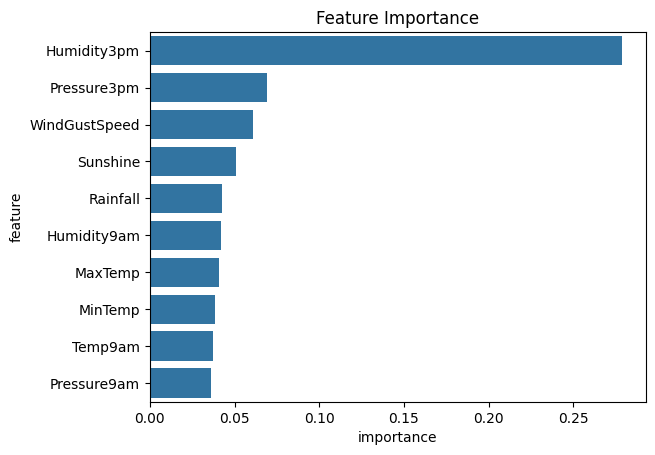

In [28]:
plt.title("Feature Importance")
sns.barplot(data=importance_df.head(10), x="importance", y="feature");

## Hyperparameter Tuning and Overfitting

Our decision tree classifier memorized all training examples, leading to a 100% training accuracy, while the validation accuracy was only marginally better than a dumb baseline model. This phenomenon is called `overfitting`.

The `DecisionTreeClassifier` accepts several arguments, some of which can be modified to reduce overfitting.

In [29]:
DecisionTreeClassifier?

Init signature:
DecisionTreeClassifier(
    *,
    criterion='gini',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    class_weight=None,
    ccp_alpha=0.0,
    monotonic_cst=None,
)
Docstring:     
A decision tree classifier.

Read more in the :ref:`User Guide <tree>`.

Parameters
----------
criterion : {"gini", "entropy", "log_loss"}, default="gini"
    The function to measure the quality of a split. Supported criteria are
    "gini" for the Gini impurity and "log_loss" and "entropy" both for the
    Shannon information gain, see :ref:`tree_mathematical_formulation`.

splitter : {"best", "random"}, default="best"
    The strategy used to choose the split at each node. Supported
    strategies are "best" to choose the best split and "random" to choose
    the best random split.

max_depth : int, default=None

These arguments are called hyperparameters because they must be configured manually (as opposed to the parameters within the model which are _learned_ from the data. Main hyperparameters:

- `max_depth`
- `max_leaf_nodes`

### `max_depth`

By reducing the maximum depth of the decision tree, we can prevent the tree from memorizing all training examples, which may lead to better generalization

In [30]:
model = DecisionTreeClassifier(max_depth=3, random_state=42)

In [31]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [32]:
model.score(X_train, train_targets)

0.8315916234640977

In [33]:
model.score(X_val, val_targets)

0.8348060155655685

Now, the model is not overfitting the training accuracy has gone down, while increasing the validation accuracy as well.

In [34]:
model.classes_

array(['No', 'Yes'], dtype=object)

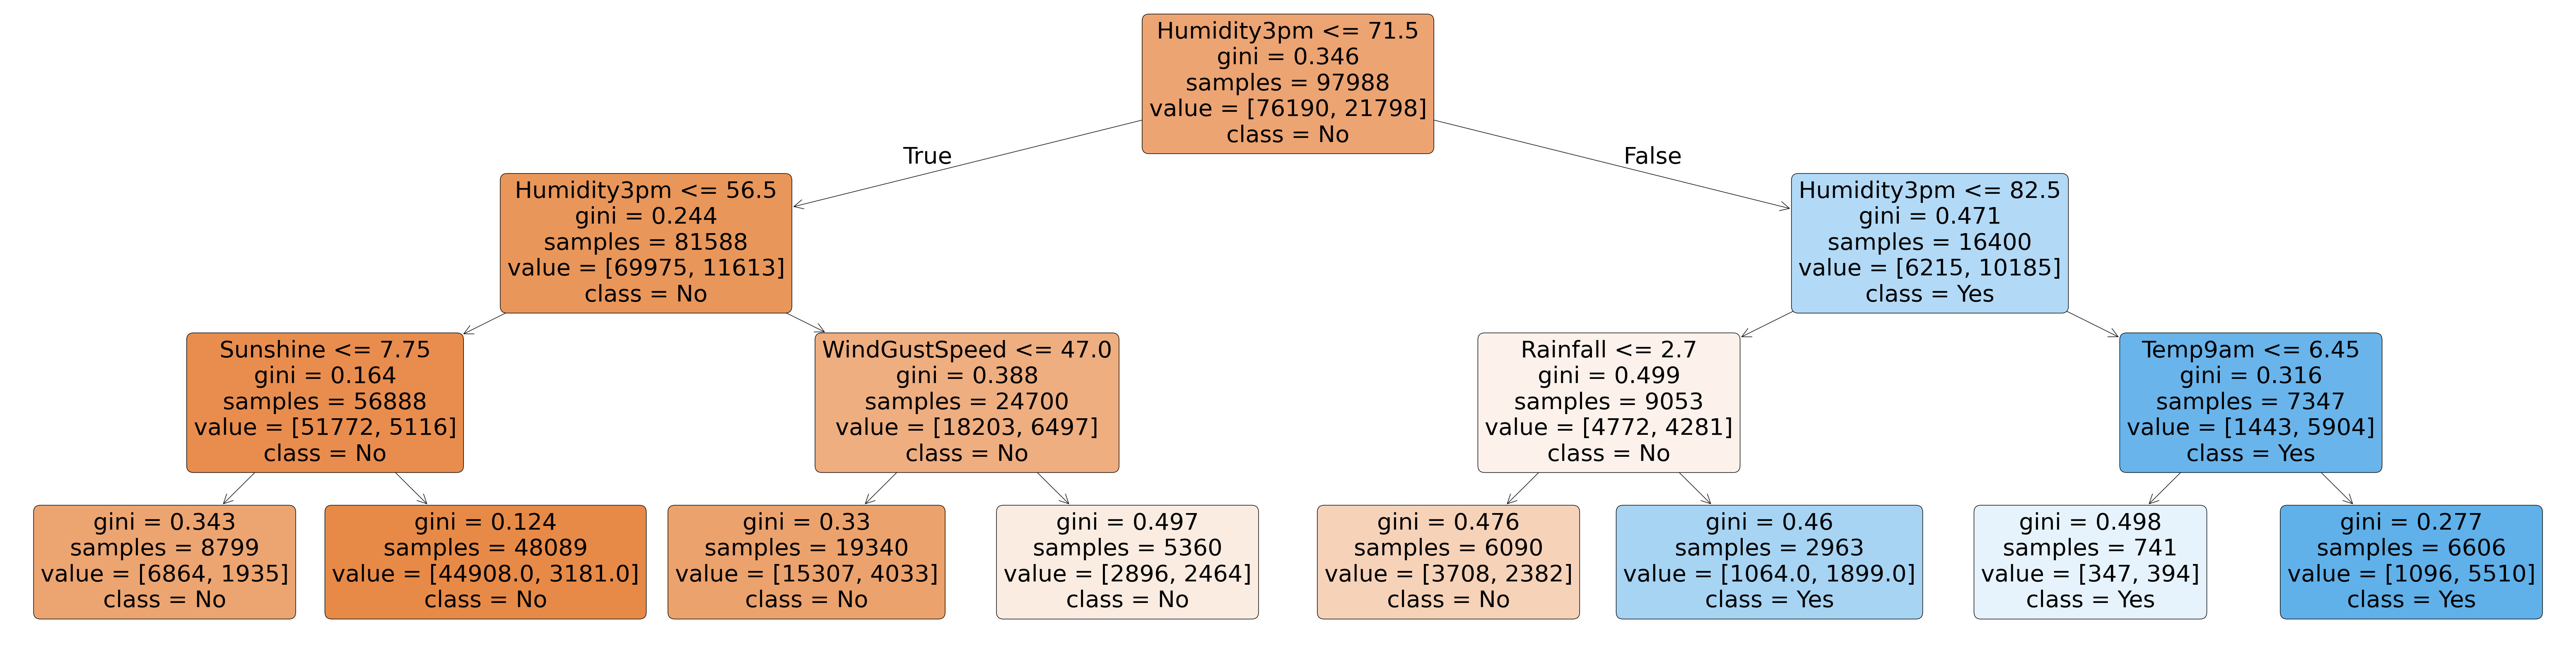

In [35]:
plt.figure(figsize=(80, 20))
plot_tree(
    model,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    class_names=model.classes_,
);

In [36]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, train_targets)
    train_acc = 1 - model.score(X_train, train_targets)
    val_acc = 1 - model.score(X_val, val_targets)
    return {"Max Depth": md, "Training Error": train_acc, "Validation Error": val_acc}

In [37]:
%%time
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

CPU times: user 18.2 s, sys: 782 ms, total: 19 s
Wall time: 20 s


In [38]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.181941,0.176488
1,2,0.176930,0.170695
2,3,0.168408,0.165194
3,4,0.161877,0.161566
4,5,0.157111,0.159401
5,6,0.152335,0.154368
6,7,0.149416,0.154017
7,8,0.145385,0.153725
8,9,0.138956,0.153959
9,10,0.131169,0.154368


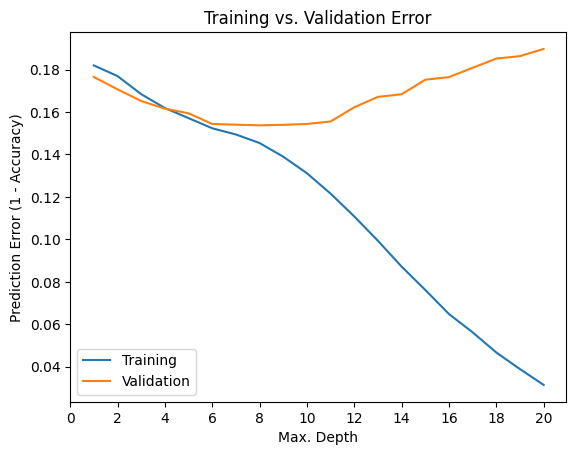

In [39]:
plt.figure()
plt.plot(errors_df["Max Depth"], errors_df["Training Error"])
plt.plot(errors_df["Max Depth"], errors_df["Validation Error"])
plt.title("Training vs. Validation Error")
plt.xticks(range(0, 21, 2))
plt.xlabel("Max. Depth")
plt.ylabel("Prediction Error (1 - Accuracy)")
plt.legend(["Training", "Validation"])

It appears that a maximum depth of 7 results in the lowest validation error.

In [40]:
model = DecisionTreeClassifier(max_depth=7, random_state=42).fit(X_train, train_targets)
model.score(X_val, val_targets)

0.8459827959506115

### `max_leaf_nodes`

Another way to control the size of complexity of a decision tree is to limit the number of leaf nodes. This allows branches of the tree to have varying depths. 

In [41]:
model = DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [42]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_leaf_nodes=128, random_state=42)

In [44]:
model.score(X_train, train_targets)

0.8526758378576969

In [43]:
model.score(X_val, val_targets)

0.8467435192228919

In [45]:
model.tree_.max_depth

10

In [60]:
model = DecisionTreeClassifier(max_depth=7, max_leaf_nodes=128, random_state=42)

In [61]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(max_depth=7, max_leaf_nodes=128, random_state=42)

In [62]:
model.score(X_train, train_targets)

0.850583744948361

In [63]:
model.score(X_val, val_targets)

0.8460413131254023

## Random Forest

Combining results from serveral improved decision tress with different parameters, is called as **Random Forest**.

A random forest works by averaging/combining the results of several decision trees:

<img src="https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif" width="640">


We'll use the `RandomForestClassifier` class from `sklearn.ensemble`.

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
model = RandomForestClassifier(n_jobs=-1, random_state=42)


In [66]:
%%time
model.fit(X_train, train_targets)

CPU times: user 20.6 s, sys: 688 ms, total: 21.2 s
Wall time: 5.88 s


RandomForestClassifier(n_jobs=-1, random_state=42)

In [67]:
model.score(X_train, train_targets)

0.9999693840062048

In [68]:
model.score(X_val, val_targets)

0.8576862309087717

The training accuracy is 100%, but this time the validation accuracy is much better with an accuracy of **85%**.

This general technique of combining the results of many models is called "**ensembling**", it works because most errors of individual models cancel out on averaging. Here's what it looks like visually:

<img src="https://i.imgur.com/qJo8D8b.png" width="480">


We can also look at the probabilities for the predictions. The probability of a class is simply the fraction of trees which that predicted the given class.

In [69]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.91, 0.09],
       [0.99, 0.01],
       [0.98, 0.02],
       ...,
       [0.98, 0.02],
       [1.  , 0.  ],
       [0.93, 0.07]], shape=(97988, 2))

In [70]:
model.estimators_[0]

DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)

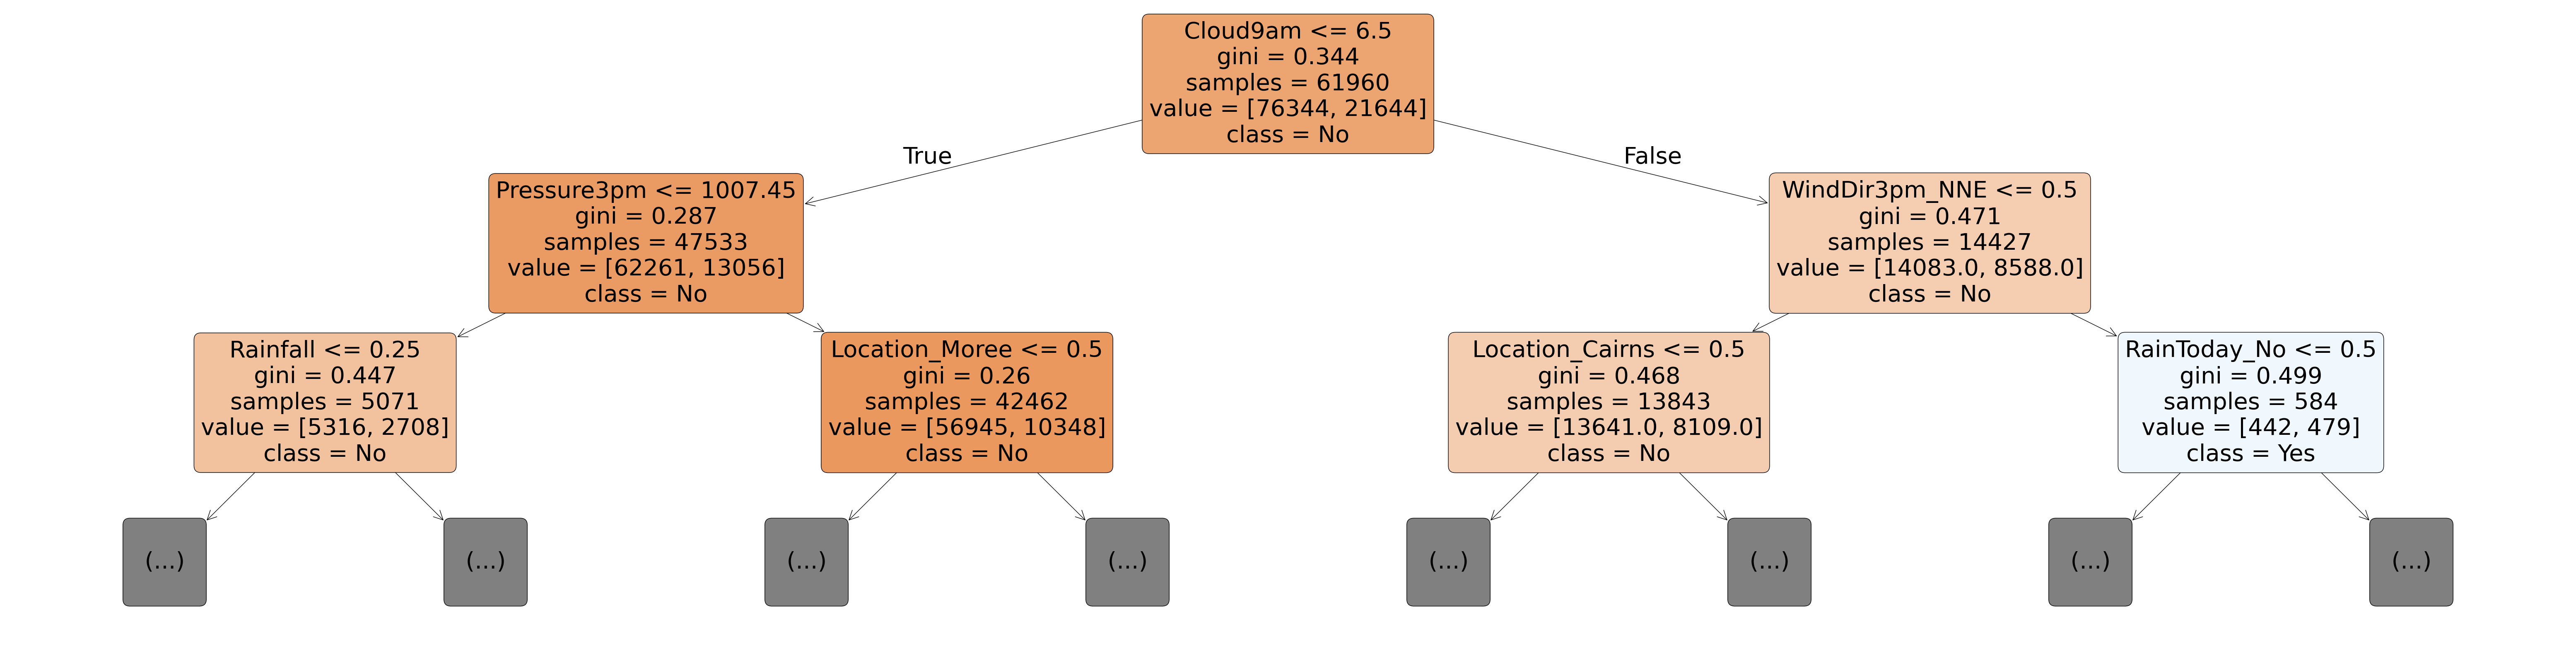

In [71]:
plt.figure(figsize=(80, 20))
plot_tree(
    model.estimators_[0],
    max_depth=2,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    class_names=model.classes_,
);

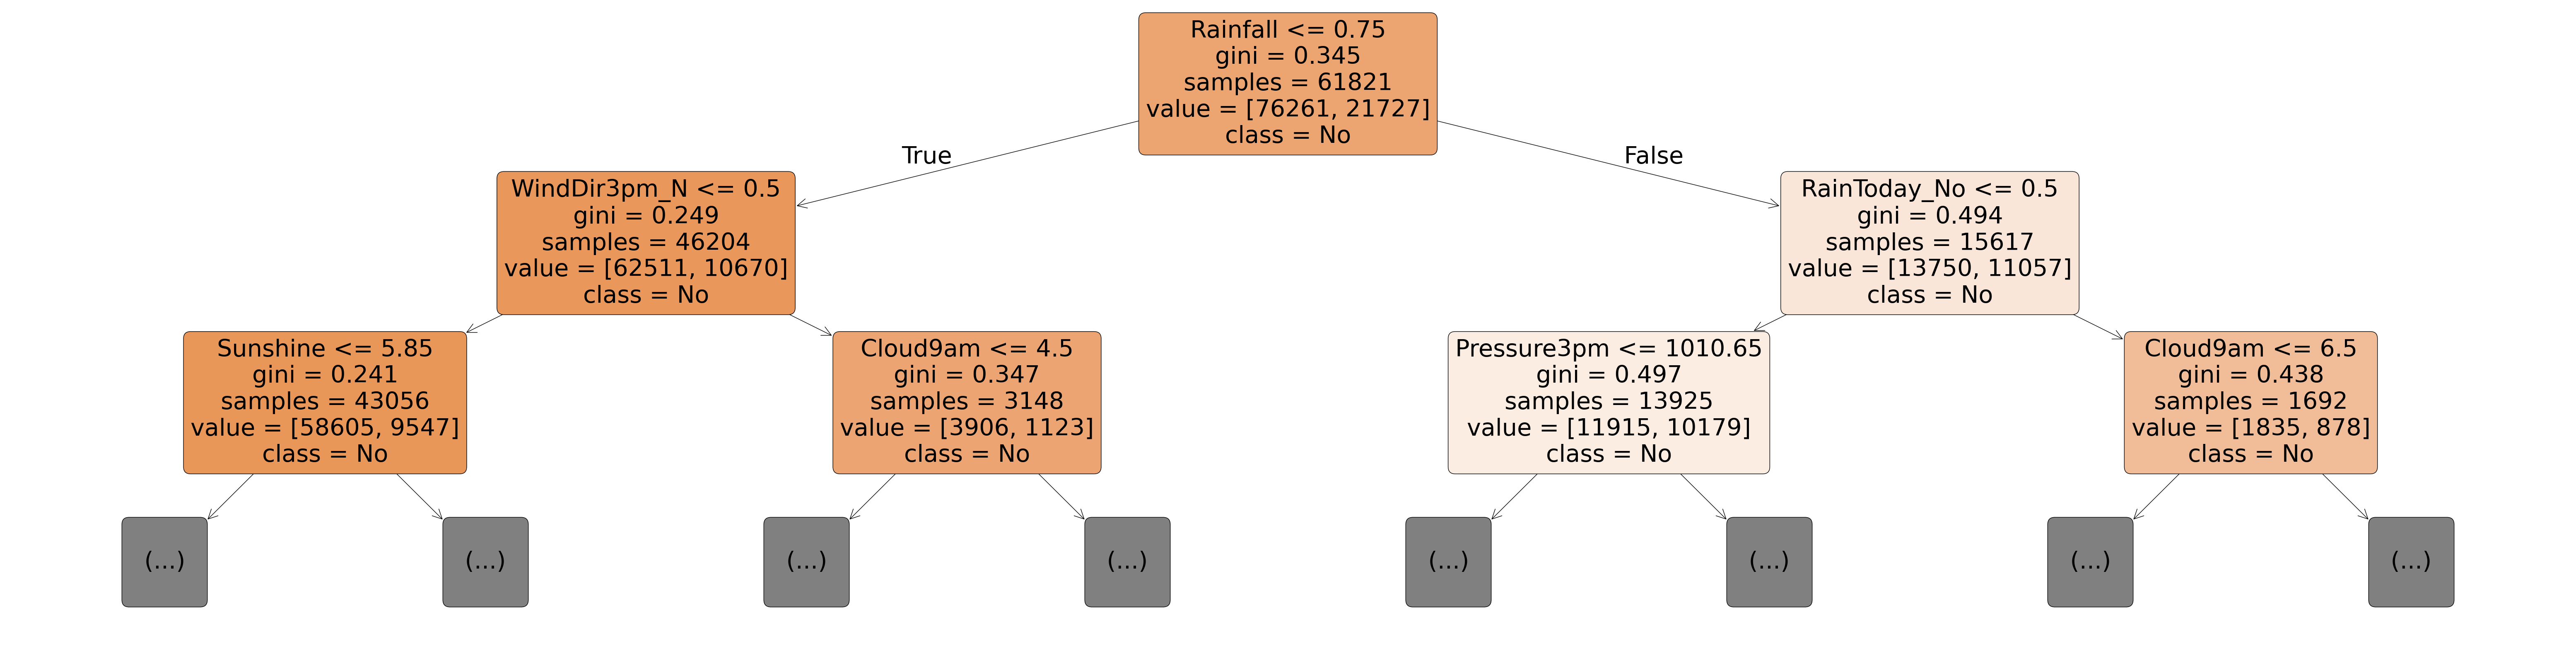

In [72]:
plt.figure(figsize=(80, 20))
plot_tree(
    model.estimators_[15],
    max_depth=2,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    class_names=model.classes_,
);

In [73]:
len(model.estimators_)

100

In [74]:
importance_df = pd.DataFrame(
    {"feature": X_train.columns, "importance": model.feature_importances_}
).sort_values("importance", ascending=False)

In [75]:
importance_df.head(10)

,feature,importance
9,Humidity3pm,0.152628
4,Sunshine,0.056350
11,Pressure3pm,0.055367
8,Humidity9am,0.053385
5,WindGustSpeed,0.051441
10,Pressure9am,0.051325
2,Rainfall,0.047122
1,MaxTemp,0.045180
0,MinTemp,0.042564
14,Temp9am,0.041023


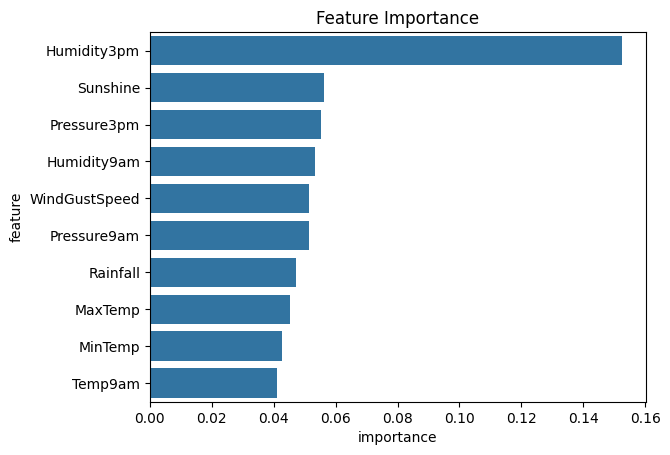

In [76]:
plt.title("Feature Importance")
sns.barplot(data=importance_df.head(10), x="importance", y="feature");

The feature importance is less skewed.

In [77]:
base_model = RandomForestClassifier(random_state=42, n_jobs=-1).fit(
    X_train, train_targets
)

In [78]:
base_train_acc = base_model.score(X_train, train_targets)
base_val_acc = base_model.score(X_val, val_targets)

In [79]:
base_accs = base_train_acc, base_val_acc
base_accs

(0.9999693840062048, 0.8576862309087717)

### `n_estimators`

This controls the number of decision trees in the random forest. The default value is 100. For larger datasets, it helps to have a greater number of estimators. As a general rule, try to have as few estimators as needed. 


**10 estimators**

In [80]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=10)

In [81]:
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [82]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9868147120055517, 0.847621276844754)

In [83]:
base_accs

(0.9999693840062048, 0.8576862309087717)

**500 estimators**

In [84]:
model = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=500)
model.fit(X_train, train_targets)

RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

In [85]:
model.score(X_train, train_targets)

0.9999795893374699

In [86]:
model.score(X_val, val_targets)

0.859675814851659

In [87]:
base_accs

(0.9999693840062048, 0.8576862309087717)

### Putting all together

In [88]:
model = RandomForestClassifier(
    n_jobs=-1,
    random_state=42,
    n_estimators=500,
    max_features=7,
    max_depth=30,
    class_weight={"No": 1, "Yes": 1.5},
)

model.fit(X_train, train_targets)

RandomForestClassifier(class_weight={'No': 1, 'Yes': 1.5}, max_depth=30,
                       max_features=7, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [89]:
model.score(X_train, train_targets), model.score(X_val, val_targets)

(0.9927950361268727, 0.8594417461524958)

In [90]:
base_accs

(0.9999693840062048, 0.8576862309087717)

We've increased the accuracy from **84.5%** with a single decision tree to **85.7%** with a well-tuned random forest.